In [2]:
from base_dataset import BaseDataset

from torchvision import transforms
import numpy as np
from PIL import Image
import cv2

from util import gen_trimap, gen_trimap_with_dilate, gen_trimap_with_dilate_bbox

/home/ubuntu/miniconda3/envs/hrnet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# root_dir = '/home/ubuntu/data/workspace/deeplabv3_plus/people_segmentation'
# ds = BaseDataset(root_dir, img_dir="images", alpha_dir="masks")

In [4]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/MODNet/data/PPM-100",
#         "image",
#         "matte")

In [5]:
# ds = BaseDataset( "/home/ubuntu/data/yong/projects/P3M/data/P3M-10k/train",
#         "blurred_image",
#         "mask")

In [6]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/Human-Segmentation-Dataset",
#         "Training_Images",
#         "Ground_Truth")

In [28]:
ds = BaseDataset( "/home/ubuntu/data/yong/dataset/human_matting_dataset_kaggle",
        "JPEGImages",
        "SegmentationClassPNG")

428 samples


In [29]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/segmentation_full_body_mads_dataset_1192_img",
#         "images",
#         "masks")

In [30]:
# ds = BaseDataset( "/home/ubuntu/data/yong/dataset/RealWorldPortrait-636",
#         "image",
#         "alpha")

In [31]:
# ds = BaseDataset("/home/ubuntu/data/yong/dataset/people_segmentation",
#         "images",
#         "profiles")

In [32]:
sample = ds[50]

In [33]:
alpha_path, weight, img, trimap, alpha = sample

In [34]:
alpha = np.array(Image.open(alpha_path))
if alpha.shape[-1] == 4:
    if len(np.unique(alpha[..., -1])) == 1:
        alpha = alpha[..., :-1]
alpha = alpha[..., -1] if len(alpha.shape) > 2 else alpha

if 'profile' in alpha_path:
    alpha = 255 - alpha

In [35]:
if np.amax(alpha) <= 1:
    alpha = alpha * 255.0

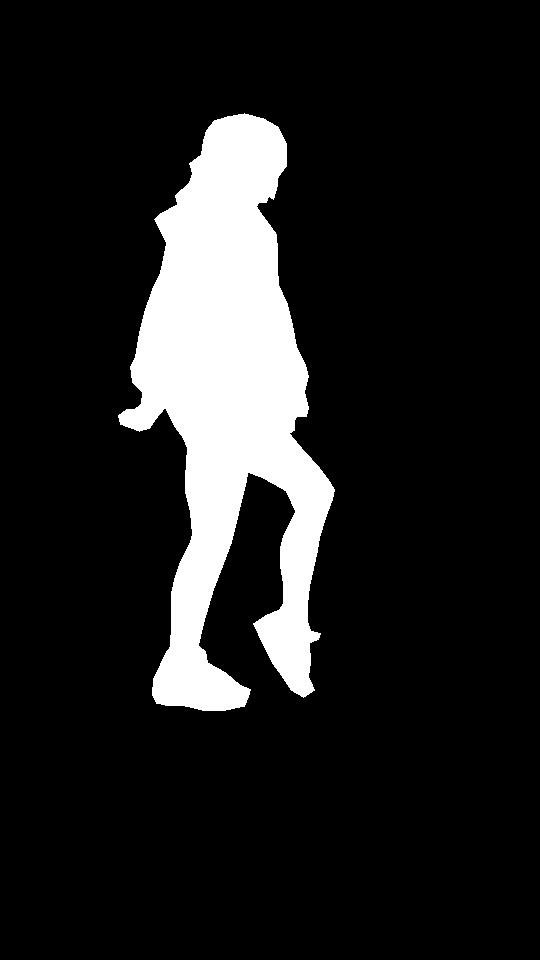

In [36]:
Image.fromarray(np.array(alpha, dtype=np.uint8))

In [37]:
np.unique(alpha)

array([  0., 255.])

In [38]:
import random

In [39]:
def get_bbox(alpha):
    foreground = alpha > 0.0
    res = None
    res = Image.fromarray(foreground).getbbox()
    if res is None:
        left, upper, right, ylower = 0, 0, alpha.shape[1], alpha.shape[0]
    else:
        left, upper, right, ylower = res
    return (left, upper, right, ylower)

In [40]:
def draw_bbox(alpha):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]
    res = cv2.rectangle(np.array(alpha, dtype=np.uint8), rect[:2], rect[2:], color = 128, thickness =2)
    return res

In [41]:
# res  = draw_bbox(alpha)
# Image.fromarray(np.array(res, dtype=np.uint8))

(512, 512)


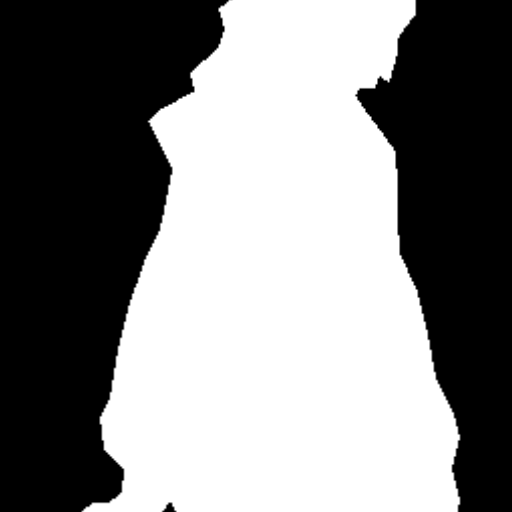

In [92]:
def resize_and_crop_by_bbox(alpha, ref_size = 512, random_scale = 1.5):
    rect = get_bbox(alpha)
    rect_width = rect[2] - rect[0]
    rect_height = rect[3] - rect[1]

    im_h, im_w = alpha.shape

    # 将BBOX裁剪出来
    width_pad = int(rect_width / 4.0)
    height_pad = int(rect_height / 4.0)
    x_start = max(rect[0] - width_pad, 0)
    x_end = min(rect[2] + width_pad, im_w - 1)
    y_start = max(rect[1] - height_pad, 0)
    y_end = min(rect[3] + height_pad, im_h - 1)
    alpha = alpha[y_start:y_end, x_start:x_end, ...]

    # 将短边缩短到512
    im_h, im_w = alpha.shape
    # 非标准512x512图片，resize到短边为ref_size~ref_size*random_scale
    # 然后center crop 或 random crop
    if not (im_h == ref_size and im_w == ref_size):
        random_size = np.random.randint(ref_size, int(ref_size * random_scale))
        if im_w >= im_h:
            im_rh = random_size
            im_rw = int(im_w / im_h * random_size)
        elif im_w < im_h:
            im_rw = random_size
            im_rh = int(im_h / im_w * random_size)

    # img = cv2.resize(img, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)
    alpha = cv2.resize(alpha, (im_rw, im_rh), interpolation=cv2.INTER_LINEAR)

    # random crop
    x0 = random.randint(0, im_rw - ref_size)
    y0 = random.randint(0, im_rh - ref_size)
    # img = img[y0:y0 + ref_size, x0:x0 + ref_size, ...]
    alpha = alpha[y0:y0 + ref_size, x0:x0 + ref_size]
    
    return alpha

res = resize_and_crop_by_bbox(alpha)
print(res.shape)
Image.fromarray(np.array(res, dtype=np.uint8))